In [1]:
%matplotlib inline
from sklearn.model_selection import learning_curve
import numpy as np
from fastFM import als
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
from fastFM import mcmc
from scipy.sparse import csr_matrix

# https://pandas.pydata.org/pandas-docs/stable/sparse.html#sparsedataframe
# http://nakano-tomofumi.hatenablog.com/entry/2017/11/06/121729


f1=pd.read_csv('dataset.csv')
f1=f1.fillna(0)
f1=f1.drop('kaiin_id', axis=1)
f1=f1.drop('model_id', axis=1)
f1=f1.drop('tori_id', axis=1)
f1=f1.drop('brand_name', axis=1)
f1=f1.drop('cate_name', axis=1)
f1=f1.drop('cate_id', axis=1)
f1=f1.drop('brand_id', axis=1)
f1=f1.drop('syo_id', axis=1)
c_name=f1.columns
df=np.array(f1)[:50000]
f1=pd.DataFrame(df)
f1.columns=c_name
print(f1.shape)

(50000, 21)


In [4]:
f1.columns

Index(['man', 'women', 'age80th', 'age90th', 'age_20th', 'suryo', 'tanka',
       'bad', 'safety_tesuryo', 'popularity_boost', 'thm_id', 'minyuka_tag',
       'model', 'line', 'series', 'kigata', 'category_level', 'label',
       'cate_sim', 'brand_sim'],
      dtype='object')

In [7]:
# ラベル
t=np.array(f1['label'])
t=[int(i) for i in t]
t=np.reshape(t, (len(t),))

# 特徴量
data=f1.drop('label', axis=1)

# 標準化
f1_columns=list(data.columns)
sc = StandardScaler()
dff = sc.fit_transform(data)
dff=pd.DataFrame(dff)
dff.columns=f1_columns
dff.head()

,man,women,age80th,age90th,age_20th,suryo,tanka,bad,safety_tesuryo,popularity_boost,thm_id,minyuka_tag,model,line,series,kigata,category_level,cate_sim,brand_sim
0,1.568429,-1.568429,-0.625961,1.289179,-0.164861,-0.067132,-0.276941,-0.077693,0.331813,-0.16985,0.646496,-0.298077,0.417742,-0.392583,-0.121891,-0.020004,0.156075,-0.906831,-0.022948
1,-0.637581,0.637581,-0.625961,1.289179,-0.164861,-0.067132,0.110181,-0.077693,0.331813,-0.16985,0.646496,-0.298077,0.417742,-0.392583,-0.121891,-0.020004,0.156075,0.229200,-0.308702
2,-0.637581,0.637581,-0.625961,-0.775688,-0.164861,-0.067132,0.205049,-0.077693,0.331813,-0.16985,-1.546800,-0.298077,0.417742,-0.392583,-0.121891,-0.020004,0.156075,0.229200,-0.233791
3,-0.637581,0.637581,-0.625961,-0.775688,-0.164861,-0.067132,-0.572255,-0.077693,0.331813,-0.16985,0.646496,3.354833,0.417742,-0.392583,-0.121891,-0.020004,0.156075,0.159443,-0.323425
4,-0.637581,0.637581,1.597544,-0.775688,-0.164861,-0.067132,0.781907,-0.077693,-3.013748,-0.16985,0.646496,3.354833,0.417742,-0.392583,-0.121891,-0.020004,0.156075,0.229200,-0.132674


In [8]:
# FM のデータ形式に加工
tmp = dff.to_dict(orient="index")
sp=[tmp[i] for i in dff.index]

vec = DictVectorizer()
X = vec.fit_transform(sp)

In [9]:
np.std(t)
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.1, random_state=42)

0.564781684571014


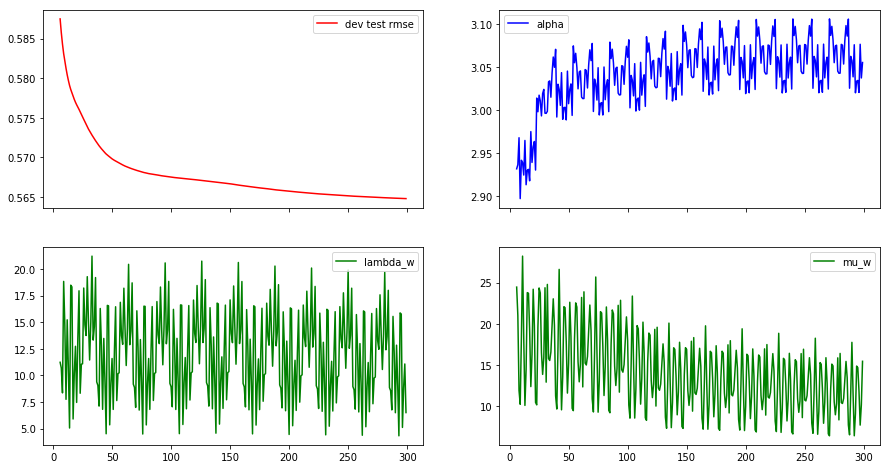

In [10]:
"""
イテレーション回数の影響 => 開発データでイテレーション回数によるRMSEの推移を確認
"""

n_iter = 300
step_size = 1
seed = 123
rank = 4


fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
# Allocates and initalizes the model and hyper parameter.
fm.fit_predict(X_train, y_train, X_test)

rmse_dev_test = []
rmse_test = []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)

for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    hyper_param[nr, :] = fm.hyper_param_

values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5
x = x[burn_in:]

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

axes[0, 0].plot(x, rmse_test[burn_in:], label='dev test rmse', color="r")
axes[0, 0].legend()
axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].legend()
axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].legend()
axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].legend()

print(np.min(rmse_test))

In [11]:
n_iter = 100
rank = 4
seed = 333
step_size = 1

fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
# initalize coefs
fm.fit_predict(X_train, y_train, X_test)

rmse_test = []
rmse_new = []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    hyper_param[nr, :] = fm.hyper_param_

------- restart ----------
iter:10 rmse:0.579
iter:20 rmse:0.573
iter:30 rmse:0.571
iter:40 rmse:0.569
iter:50 rmse:0.567
iter:60 rmse:0.567
iter:70 rmse:0.566
iter:80 rmse:0.566
iter:90 rmse:0.565


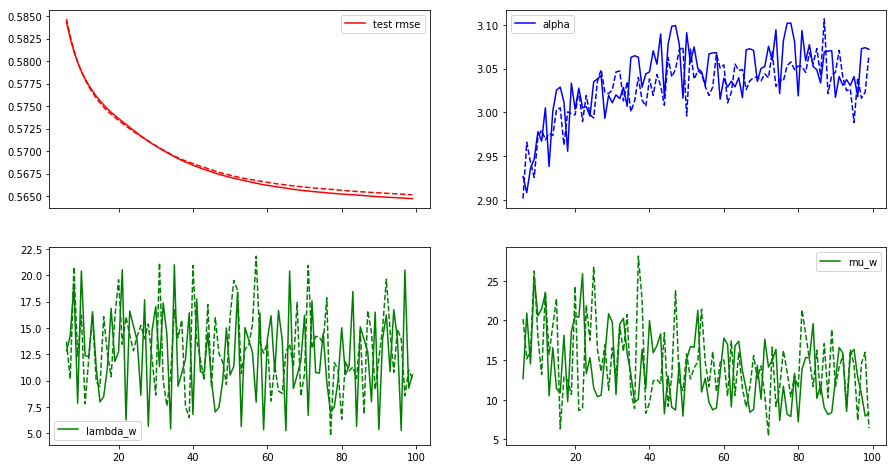

min rmse: 0.565


In [12]:
"""
n_iterのRMSEへの影響を確認
"""

print('------- restart ----------')
values = np.arange(1, n_iter)
rmse_test_re = []
hyper_param_re = np.zeros((len(values), 3 + 2 * rank), dtype=np.float64)
for nr, i in enumerate(values):
    fm = mcmc.FMRegression(n_iter=i, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmse_test_re.append(rmse)
    hyper_param_re[nr, :] = fm.hyper_param_
    if i % 10 == 0:
        print('iter:{} rmse:{:.3f}'.format(i, rmse))

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

x = values * step_size
burn_in = 5
x = x[burn_in:]

#with plt.style.context('ggplot'):
axes[0, 0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
axes[0, 0].plot(values[burn_in:], rmse_test_re[burn_in:], ls="--", color="r")
axes[0, 0].legend()

axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].plot(values[burn_in:], hyper_param_re[burn_in:,0], ls="--", color="b")
axes[0, 1].legend()

axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].plot(values[burn_in:], hyper_param_re[burn_in:,1], ls="--", color="g")
axes[1, 0].legend()

axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].plot(values[burn_in:], hyper_param_re[burn_in:,3], ls="--", color="g")
axes[1, 1].legend()

plt.show()
print("min rmse: {:.3f}".format(np.min(rmse_test_re)))

rank:4	rmse:0.616
rank:8	rmse:0.615
rank:16	rmse:0.615
rank:32	rmse:0.615
rank:64	rmse:0.615
min rmse: 0.615


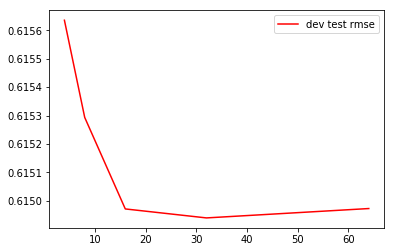

In [10]:
"""
Rankの影響 => 交互作用のランクによるRMSEへの影響を確認
"""
n_iter = 100
seed = 333

rmse_test = []

ranks = [4, 8, 16, 32, 64]


for rank in ranks:
    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmse_test.append(rmse)
    print('rank:{}\trmse:{:.3f}'.format(rank, rmse))

plt.plot(ranks, rmse_test, label='dev test rmse', color="r")
plt.legend()

print("min rmse: {:.3f}".format(np.min(rmse_test)))

seed:123	rmse:0.635
seed:200	rmse:0.565
seed:333	rmse:0.611
seed:450	rmse:0.610
seed:550	rmse:0.563
min rmse: 0.563


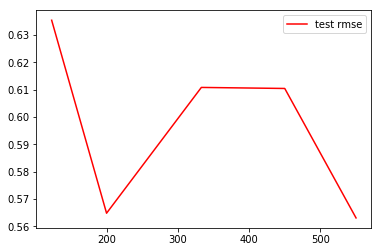

In [14]:
"""
seedのRMSEへの影響を確認
"""


n_iter = 100
rank = 32

rmse_test = []

seeds = [123, 200, 333, 450, 550]


for seed in seeds:
    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmse_test.append(rmse)
    print('seed:{}\trmse:{:.3f}'.format(seed, rmse))

plt.plot(seeds, rmse_test, label='test rmse', color="r")
plt.legend()

print("min rmse: {:.3f}".format(np.min(rmse_test)))

In [15]:
# evalation
seed=200
fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
fm.fit_predict(X_train, y_train, X_test)
y_pred = fm.fit_predict(X_train, y_train, X_test)
np.sqrt(mean_squared_error(y_pred, y_test))

0.5685622423647096

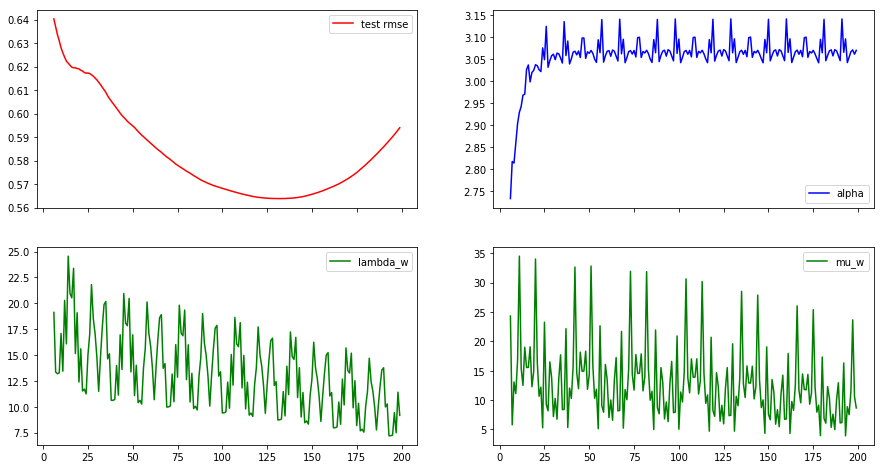

In [16]:
n_iter = 200
step_size = 1
seed = 200
rank = 32

fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
# Allocates and initalizes the model and hyper parameter.
fm.fit_predict(X_train, y_train, X_test)

rmse_test = []
rmse_new = []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    hyper_param[nr, :] = fm.hyper_param_

values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5
x = x[burn_in:]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

axes[0, 0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
axes[0, 0].legend()
axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].legend()
axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].legend()
axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].legend()

In [17]:
values = np.arange(0, n_iter)
x = values * step_size
print("min rmse: {:.3f}, argmin: {}".format(np.min(rmse_test), x[np.argmin(rmse_test)]))

min rmse: 0.564, argmin: 130


In [20]:
"""
特徴量の組み合わせによる変化 => 利用する特徴量の組み合わせを変化させて、その効果を検証
"""

candidate_columns = [
    ['man', 'women', 'age80th', 'age90th', 'age_20th', 'suryo', 'tanka', 'bad', 'safety_tesuryo', 'popularity_boost',
    'thm_id', 'minyuka_tag', 'model', 'line', 'series', 'kigata', 'category_level', 'cate_sim', 'brand_sim'], # A
    ['man','age90th', 'tanka','series', 'category_level', 'cate_sim', 'brand_sim'], # B
    ['man', 'women', 'age80th', 'suryo', 'tanka', 'safety_tesuryo', 'thm_id', 'minyuka_tag', 'cate_sim'],  # C
]

rmse_test = []

n_iter = 500
seed = 123
rank = 32


for column in candidate_columns:
    data=f1.drop('label', axis=1)
    filtered = data[column].dropna()
    fil_columns=list(filtered.columns)
    sc = StandardScaler()
    df = sc.fit_transform(filtered)
    df=pd.DataFrame(df)
    df.columns=fil_columns
    tmp = df.to_dict(orient="index")
    filtered_vec=[tmp[i] for i in df.index]

    vec = DictVectorizer()
    X_ = vec.fit_transform(filtered_vec)
    
    t_=np.array(f1['label'])
    t_=[int(i-1) for i in t_]
    t_=np.reshape(t_, (len(t_),))

    X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(X_, t_, test_size=0.1, random_state=42)

    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    # Allocates and initalizes the model and hyper parameter.
    fm.fit_predict(X_mf_train, y_mf_train, X_mf_test)

    y_pred = fm.fit_predict(X_mf_train, y_mf_train, X_mf_test)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_mf_test)))

print(rmse_test)

[0.7570218143585619, 0.5725753921133909, 0.6498780485610249]


(0.1, 1.0)

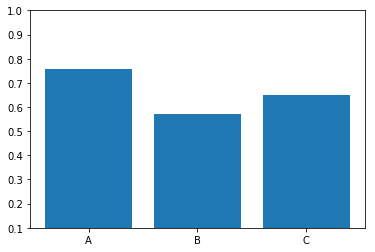

In [21]:
ind = np.arange(len(rmse_test))
bar = plt.bar(ind, height=rmse_test)
plt.xticks(ind, ('A', 'B', 'C',))
plt.ylim((0.1, 1.00))

In [28]:
import joblib
# save model
joblib.dump(fm, 'fm.model') 

# load model
fm = joblib.load('fm.model')

['fm.model']